<a href="https://colab.research.google.com/github/Sejong-Kaggle-Challengers-2nd/Cho-D-YoungRae/blob/main/5/5%EB%93%B1%EC%BD%94%EB%93%9C%EA%B3%B5%EB%B6%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [컴퓨터 비전 학습 경진대회](https://dacon.io/competitions/official/235626/overview/description/)
> [5등 코드](https://dacon.io/competitions/official/235626/codeshare/1675?page=2&dtype=recent) 공부

6가지의 모델을 Ensemble하여 사용하였습니다.

모델: thin_resnet, xception, inception, densenet, vggnet, resnet
thin_resnet은 resnet기반으로 만든 조금 작은 모델입니다.
나머지 모델들은 keras(tensorflow)의 application을 그대로 사용하였습니다.

train dataset으로 학습을 시키고 test dataset을 predict한 결과 중 일정 점수 이상을 받은 데이터들을 train dataset에 추가하여 다시 학습하였습니다.

Ensemble은 여러 모델의 각 fold로 예측한 값의 root sum을 사용하였고,
Loss는 mse, optimizer는 adam을 사용하였습니다.

Data Augmentation은 keras의 RandomRotation과 직접 구현한 RandomRoll을 사용하였습니다. keras의 RandomTranslation은 성능이 좋지 않아 사용하지 않았습니다.

In [ ]:
!nvidia-smi

Fri Apr  9 00:57:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import time
import glob
import shutil
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from albumentations import Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip, Rotate, RandomCrop, RandomBrightnessContrast

import tensorflow as tf
# import tensorflow_addons as tfa # 사용 안 되는 듯
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D, Permute
from tensorflow.keras.layers import MaxPooling1D, Dropout, Reshape, Multiply, Conv2D, MaxPool2D, LSTM, Add, Lambda, AveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D, LeakyReLU, PReLU, GlobalAveragePooling2D, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomTranslation, RandomRotation, RandomZoom
# from tensorflow_addons.layers.netvlad import NetVLAD # 사용 안 되는 듯
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 
from tensorflow.keras.applications import ResNet50, ResNet152
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import EfficientNetB7, EfficientNetB4, EfficientNetB2, EfficientNetB1
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import InceptionV3
import subprocess as sp
import os

In [ ]:
file_dir = "/content/drive/MyDrive/kaggle-study/5/data/"

train_csv = pd.read_csv(file_dir + 'train.csv')
test_csv = pd.read_csv(file_dir + 'test.csv')
submission_csv = pd.read_csv(file_dir + 'submission.csv')

In [ ]:
train_csv.head()

,id,digit,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,4,4,3,0,4,3,3,3,4,4,0,0,1,1,3,4,0,4,2,0,4,0,1,3,1,0,4,1,1,3,...,4,3,4,1,3,0,0,1,3,3,3,0,3,2,2,1,0,1,0,0,3,0,0,4,2,0,3,4,1,1,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,1,4,2,0,3,4,0,0,2,3,4,0,3,4,3,0,2,2,1,4,2,3,3,4,1,2,4,2,0,3,...,4,2,3,0,0,0,0,4,3,2,2,4,2,1,1,1,3,3,1,2,4,4,4,2,2,4,4,0,4,2,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,0,2,1,3,2,2,2,4,1,1,4,1,0,1,3,4,2,2,2,4,1,1,2,0,3,0,2,3,4,0,...,3,0,4,0,3,0,2,0,1,4,2,3,4,4,4,0,2,0,4,4,1,3,0,3,2,0,2,3,0,2,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,3,4,3,1,0,3,2,2,0,3,4,1,0,4,1,2,2,3,2,2,0,2,0,3,0,3,2,4,0,0,...,0,3,0,1,4,1,3,1,2,1,1,1,2,2,2,4,3,4,3,0,4,1,2,4,1,4,0,1,0,4,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,4,2,4,2,1,4,1,1,4,4,0,2,3,4,4,3,3,3,3,4,1,0,3,0,3,0,0,0,1,1,...,2,1,3,2,1,4,2,3,2,2,1,0,4,2,2,1,2,1,0,3,2,2,2,2,1,4,2,1,2,1,4,4,3,2,1,3,4,3,1,2


In [ ]:
label_encoder = LabelEncoder()

# TRAIN
train_letters_char = train_csv['letter'].values
train_letters_int = label_encoder.fit_transform(train_letters_char)
train_letters = keras.utils.to_categorical(train_letters_int)

train_pixels = train_csv.loc[:, '0':'783'].values
train_pixels = train_pixels.astype(np.float32)
train_pixels = train_pixels.reshape((-1, 28, 28, 1))

train_digits_int = train_csv['digit'].values
train_digits = keras.utils.to_categorical(train_digits_int)

위 전처리 어떤 과정으로 되는건지

In [ ]:
train_csv['letter'].values

array(['L', 'B', 'L', ..., 'A', 'Z', 'Z'], dtype=object)

In [ ]:
label_encoder.transform(train_letters_char)

array([11,  1, 11, ...,  0, 25, 25])

In [ ]:
keras.utils.to_categorical(train_letters_int)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

`keras.utils.to_categorical()`은 정수형만 원핫 인코딩 시켜주는 듯

```python
keras.utils.to_categorical(train_letters_char)
```
```
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-16-6314712126be> in <module>()
----> 1 keras.utils.to_categorical(train_letters_char)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/np_utils.py in to_categorical(y, num_classes, dtype)
     67 
     68   """
---> 69   y = np.array(y, dtype='int')
     70   input_shape = y.shape
     71   if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:

ValueError: invalid literal for int() with base 10: 'L'
```

In [ ]:
# TEST
test_letters_char = test_csv['letter'].values
test_letters_int = label_encoder.fit_transform(test_letters_char)
test_letters = keras.utils.to_categorical(test_letters_int)

test_pixels = test_csv.loc[:, '0':'783'].values
test_pixels = test_pixels.astype(np.float32)
test_pixels = test_pixels.reshape((-1, 28, 28, 1))

print(train_letters.shape, train_letters.dtype)
print(train_digits.shape, train_digits.dtype)
print(train_pixels.shape, train_pixels.dtype)

print(test_letters.shape, test_letters.dtype)
print(test_pixels.shape, test_pixels.dtype)

(2048, 26) float32
(2048, 10) float32
(2048, 28, 28, 1) float32
(20480, 26) float32
(20480, 28, 28, 1) float32


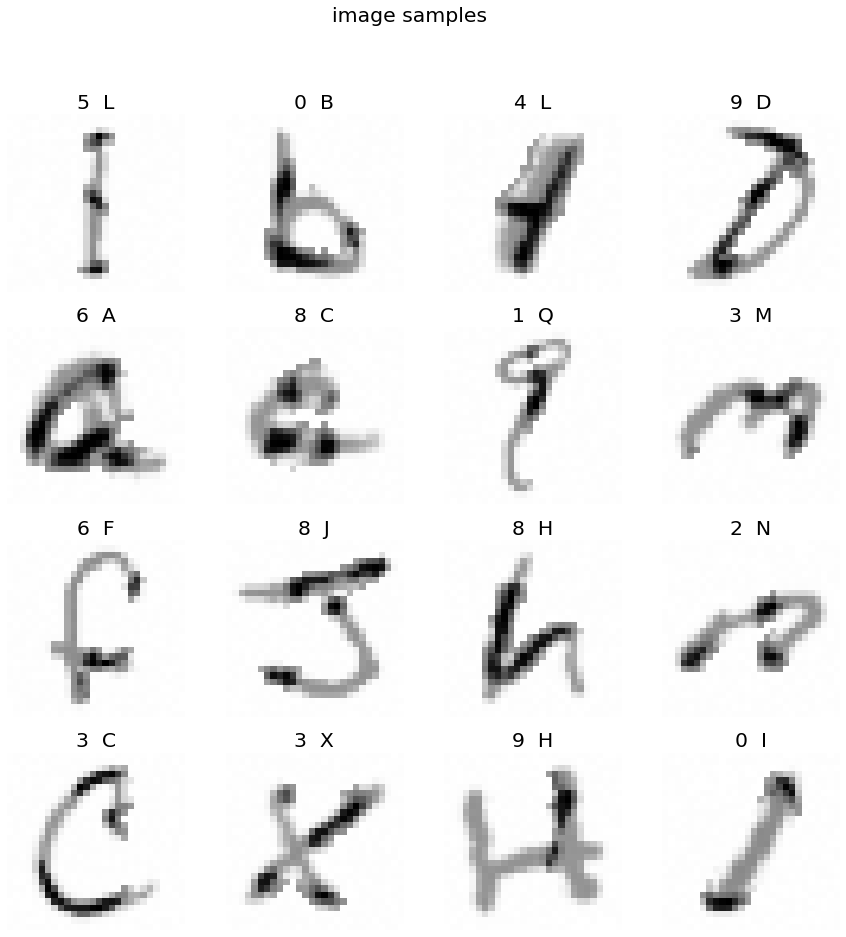

In [ ]:
# train 이미지 확인

plt.rcParams.update({'font.size': 17})
fig, axs = plt.subplots(4, 4)
fig.suptitle('image samples')
fig.set_size_inches(15, 15)

# train_pixels[train_pixels < 0.6] = 0

for i in range(len(axs)):
    for j in range(len(axs[i])):
        img = train_pixels[i * 4 + j].reshape((28, 28))
        # img[img < 150] = 0.0
        # img[img >= 150] = 1.0
        axs[i][j].imshow(img, cmap='Greys')
        axs[i][j].axis('off')
        axs[i][j].title.set_text(f'{train_digits_int[i * 4 + j]}  {train_letters_char[i * 4 + j]}')
plt.show()

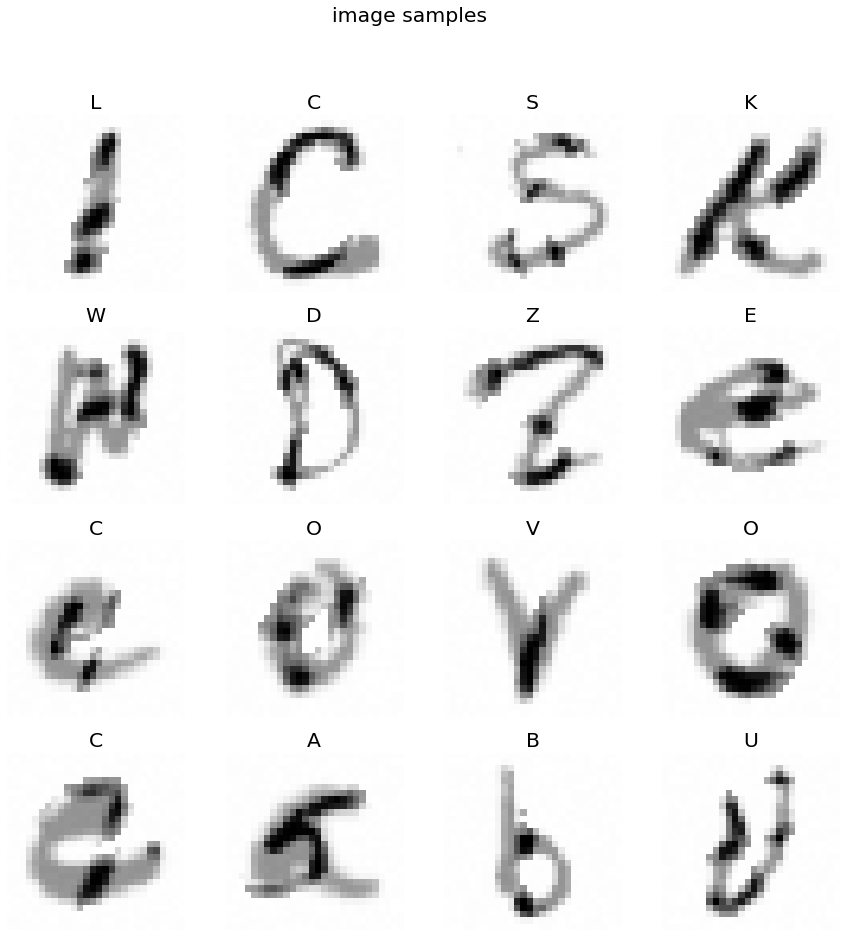

In [ ]:
# test 이미지 확인

plt.rcParams.update({'font.size': 17})
fig, axs = plt.subplots(4, 4)
fig.suptitle('image samples')
fig.set_size_inches(15, 15)

# train_pixels[train_pixels < 0.6] = 0

for i in range(len(axs)):
    for j in range(len(axs[i])):
        img = test_pixels[i * 4 + j].reshape((28, 28))
        # img[img < 150] = 0
        # img[img >= 150] = 1
        axs[i][j].imshow(img, cmap='Greys')
        axs[i][j].axis('off')
        axs[i][j].title.set_text(f'{test_letters_char[i * 4 + j]}')
plt.show()

In [ ]:
# 0번째는 n_samples(샘플의 수)

input_shape_1 = train_letters.shape[1:]
input_shape_2 = train_pixels.shape[1:]
output_size = train_digits.shape[1]

print(input_shape_1)
print(input_shape_2)
print(output_size)

(26,)
(28, 28, 1)
10


### [tf.keras.layers.Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer?hl=ko)
### [사용자 정의 층 구현](https://www.tensorflow.org/tutorials/customization/custom_layers?hl=ko)
사용자 정의 층을 구현하는 가장 좋은 방법은 tf.keras.Layer 클래스를 상속하고 다음과 같이 구현하는 것입니다.

- `__init__` 에서 층에 필요한 매개변수를 입력 받습니다.
- `build`, 입력 텐서의 크기를 얻고 남은 초기화를 진행할 수 있습니다
- `call`, 정방향 연산(forward computation)을 진행 할 수 있습니다.

변수를 생성하기 위해 build가 호출되길 기다릴 필요가 없다는 것에 주목하세요. 또한 변수를 __init__에 생성할 수도 있습니다. 그러나 build에 변수를 생성하는 유리한 점은 층이 작동할 입력의 크기를 기준으로 나중에 변수를 만들 수 있다는 것입니다. 반면에, __init__에 변수를 생성하는 것은 변수 생성에 필요한 크기가 명시적으로 지정되어야 함을 의미합니다.




In [ ]:
# 픽셀을 가로, 세로로 민다.
class RandomRollLayer(tf.keras.layers.Layer):
    """Shift data"""

    def __init__(self, roll_limit=0.1, u=0.5, **kwargs):
        super().__init__(**kwargs)
        self.roll_limit = roll_limit
        self.u = u

    def build(self, input_shape):
        self.non_trainable_weights.append(self.roll_limit)
        self.non_trainable_weights.append(self.u)
        super().build(input_shape)

    def call(self, pixels, training=None):
        if training is None:
            # 학습 단계를 나타내는 플래그 반환 : 0 = 테스트, 1 = 학습
            training = K.learning_phase()

        if not training:
            return pixels

        # 한 개의 [0, 1) 랜덤 값 반환
        if tf.random.uniform(shape=[]) < self.u:
            roll_limit = self.roll_limit * pixels.shape[1]
            roll_limit = tf.cast(roll_limit, tf.int32)
            roll = tf.random.uniform(shape=[], minval=-roll_limit, maxval=roll_limit, dtype=tf.int32)

            pixels = tf.roll(pixels, shift=roll, axis=1)

        if tf.random.uniform(shape=[]) < self.u:
            roll_limit = self.roll_limit * pixels.shape[2]
            roll_limit = tf.cast(roll_limit, tf.int32)
            roll = tf.random.uniform(shape=[], minval=-roll_limit, maxval=roll_limit, dtype=tf.int32)

            pixels = tf.roll(pixels, shift=roll, axis=2)
            
        return pixels

    # Returns a dictionary containing the configuration used to initialize this layer. 
    def get_config(self):
        config = {
            'roll_limit': self.roll_limit,
            'u': self.u,
        }
        # update 를 먼저 호출해야되지 않을까...?
        config.update(super().get_config())

        return config

# 픽셀에 랜덤하게 특정값을 더해준다
class RandomAddLayer(tf.keras.layers.Layer):
    """Add data"""

    def __init__(self, add_limit=0.1, u=0.5, **kwargs):
        super().__init__(**kwargs)
        self.add_limit = add_limit
        self.u = u

    def build(self, input_shape):
        self.non_trainable_weights.append(self.add_limit)
        self.non_trainable_weights.append(self.u)
        super().build(input_shape)

    def call(self, pixels, training=None):
        if training is None:
            training = K.learning_phase()

        if not training:
            return pixels

        if tf.random.uniform(shape=[]) < self.u:
            add = tf.random.uniform(shape=[], minval=-self.add_limit, maxval=self.add_limit, dtype=tf.float32)
            pixels = pixels + add

        return pixels

    def get_config(self):
        config = {
            'add_limit': self.add_limit,
            'u': self.u,
        }
        config.update(super().get_config())

        return config

# 픽셀에 랜덤하게 값을 곱해준다
class RandomMultipleLayer(tf.keras.layers.Layer):
    """Multiple data"""

    def __init__(self, multiple_limit=0.5, u=0.5, **kwargs):
        super().__init__(**kwargs)
        self.multiple_limit = multiple_limit
        self.u = u

    def build(self, input_shape):
        self.non_trainable_weights.append(self.multiple_limit)
        self.non_trainable_weights.append(self.u)
        super().build(input_shape)

    def call(self, pixels, training=None):
        if training is None:
            training = K.learning_phase()

        if not training:
            return pixels

        if tf.random.uniform(shape=[]) < self.u:
            multiple = tf.random.uniform(shape=[], minval=-self.multiple_limit, maxval=self.multiple_limit, dtype=tf.float32)
            pixels = pixels * (1 + multiple)

        return pixels
    
    def get_config(self):
        config = {
            'multiple_limit': self.multiple_limit,
            'u': self.u,
        }
        config.update(super().get_config())

        return config

In [ ]:
def thin_resnet_model(input_shape_1, input_shape_2, output_size=10, num_clusters=10):
    input_1 = Input(shape=input_shape_1)  # letter
    input_2 = Input(shape=input_shape_2)  # pixel

    y = input_2
    # 픽셀값 [-1, 1]범위로 rescaling
    y = Rescaling(scale=1.0/127.5, offset=-1.0)(y)
    y = RandomRollLayer(roll_limit=0.2, u=0.8)(y)
    y = RandomRotation(factor=(-0.1, 0.1), fill_mode='constant')(y)

    # y = RandomTranslation(0.1, 0.1)(y)
    # y = RandomRotation(0.1)(y)
    # y = RandomZoom(0.1)(y)

    # CONV 1
    y = Conv2D(64, (7, 7), padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = MaxPool2D((2, 2), strides=(2, 2))(y)

    # CONV 2 - 1
    y1 = Conv2D(48, (1, 1), padding='valid')(y)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(48, (3, 3), padding='same')(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(96, (1, 1), padding='valid')(y1)
    y1 = BatchNormalization()(y1)
    
    y2 = Conv2D(96, (1, 1), padding='valid')(y)
    y2 = BatchNormalization()(y2)
    y = Add()([y1, y2])
    y = Activation('relu')(y)

    # CONV 2 - 2
    y1 = Conv2D(48, (1, 1), padding='valid')(y)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(48, (3, 3), padding='same')(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(96, (1, 1), padding='valid')(y1)
    y1 = BatchNormalization()(y1)
    
    y = Add()([y1, y])
    y = Activation('relu')(y)


    # CONV 3 - 1
    y1 = Conv2D(96, (1, 1), padding='valid', strides=(2, 2))(y)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(96, (3, 3), padding='same')(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(128, (1, 1), padding='valid')(y1)
    y1 = BatchNormalization()(y1)

    y2 = AveragePooling2D((2, 2), strides=2, padding='same')(y)
    y2 = Conv2D(128, (1, 1), padding='valid')(y2)
    # y2 = Conv2D(128, (1, 1), padding='valid', strides=(2, 2))(y)
    y2 = BatchNormalization()(y2)
    y = Add()([y1, y2])
    y = Activation('relu')(y)
  
    # CONV 3 - 2
    y1 = Conv2D(96, (1, 1), padding='valid')(y)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(96, (3, 3), padding='same')(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(128, (1, 1), padding='valid')(y1)
    y1 = BatchNormalization()(y1)

    y = Add()([y1, y])
    y = Activation('relu')(y)

    # CONV 4 - 1
    y1 = Conv2D(128, (1, 1), padding='valid', strides=(2, 2))(y)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(128, (3, 3), padding='same')(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(256, (1, 1), padding='valid')(y1)
    y1 = BatchNormalization()(y1)

    # y2 = Conv2D(256, (1, 1), padding='valid', strides=(2, 2))(y)
    y2 = AveragePooling2D((2, 2), strides=2, padding='same')(y)
    y2 = Conv2D(256, (1, 1), padding='valid')(y2)
    y2 = BatchNormalization()(y2)
    y = Add()([y1, y2])
    y = Activation('relu')(y)

    # CONV 4 - 2
    y1 = Conv2D(128, (1, 1), padding='valid')(y)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(128, (3, 3), padding='same')(y1)
    y1 = BatchNormalization(gamma_initializer='zeros')(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(256, (1, 1), padding='valid')(y1)
    y1 = BatchNormalization()(y1)

    y = Add()([y1, y])
    y = Activation('relu')(y)

    # CONV 5 - 1
    y1 = Conv2D(256, (1, 1), padding='valid', strides=(2, 2))(y)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(256, (3, 3), padding='same')(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(512, (1, 1), padding='valid')(y1)
    y1 = BatchNormalization()(y1)

    # y2 = Conv2D(512, (1, 1), padding='valid', strides=(2, 2))(y)
    y2 = AveragePooling2D((2, 2), strides=2, padding='same')(y)
    y2 = Conv2D(512, (1, 1), padding='valid')(y2)
    y2 = BatchNormalization()(y2)
    y = Add()([y1, y2])
    y = Activation('relu')(y)

    # CONV 5 - 2
    y1 = Conv2D(256, (1, 1), padding='valid')(y)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(256, (3, 3), padding='same')(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(512, (1, 1), padding='valid')(y1)
    y1 = BatchNormalization()(y1)

    y = Add()([y1, y])
    y = Activation('relu')(y)

    # CONV 6
    y = Conv2D(512, (2, 2), padding='valid')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    # y = Reshape((-1, 512))(y)
    # y = Flatten()(y)
    y = GlobalAveragePooling2D()(y)
    # y = NetVLAD(num_clusters=num_clusters)(y)
    
    # 여기서 letter와 합침
    y = tf.keras.layers.Concatenate(axis=1)([y, input_1])
    y = Dropout(0.3)(y)

    y = Dense(output_size)(y)
    y = Activation('softmax')(y)
    output = y

    model = Model(inputs=[input_1, input_2], outputs=output, name='thin_resnet_model')
    # optimizer = tfa.optimizers.AdamW(learning_rate=0.05, weight_decay=0.0001)
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    

    return model

In [ ]:
def vggnet_model(input_shape_1, input_shape_2, output_size=10):
    input_1 = Input(shape=input_shape_1)  # letter
    input_2 = Input(shape=input_shape_2)  # pixel

    y = input_2

    y = Rescaling(scale=1.0/127.5, offset=-1.0)(y)
    y = tf.keras.layers.experimental.preprocessing.Resizing(height=56, width=56)(y)
    y = RandomRollLayer(roll_limit=0.2, u=0.8)(y)
   

    model = VGG19(include_top=False, input_tensor=y, pooling='max', input_shape=y.shape[1:], weights=None)

    y = model.output
    y = Dense(1024)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = tf.keras.layers.Concatenate(axis=1)([y, input_1])
    y = Dense(256)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dense(output_size, activation='softmax', name='softmax')(y)

    output = y

    model = Model(inputs=[input_1, input_2], outputs=output, name='vggnet_model')
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    return model
    

In [ ]:
def resnet_model(input_shape_1, input_shape_2, output_size=10):
    input_1 = Input(shape=input_shape_1)  # letter
    input_2 = Input(shape=input_shape_2)  # pixel

    y = input_2

    y = Rescaling(scale=1.0/127.5, offset=-1.0)(y)
    y = tf.keras.layers.experimental.preprocessing.Resizing(height=56, width=56)(y)
    y = RandomRollLayer(roll_limit=0.2, u=0.8)(y)
   

    model = ResNet101V2(include_top=False, input_tensor=y, pooling='max', input_shape=y.shape[1:], weights=None)

    y = model.output
    y = Dense(1024)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = tf.keras.layers.Concatenate(axis=1)([y, input_1])
    y = Dense(256)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dense(output_size, activation='softmax', name='softmax')(y)

    output = y

    model = Model(inputs=[input_1, input_2], outputs=output, name='resnet_model')
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    return model
    

In [ ]:
def densenet_model(input_shape_1, input_shape_2, output_size=10):
    input_1 = Input(shape=input_shape_1)  # letter
    input_2 = Input(shape=input_shape_2)  # pixel

    y = input_2

    y = Rescaling(scale=1.0/127.5, offset=-1.0)(y)
    y = tf.keras.layers.experimental.preprocessing.Resizing(height=112, width=112)(y)
    y = RandomRollLayer(roll_limit=0.2, u=0.8)(y)
    y = RandomRotation(factor=(-0.1, 0.1), fill_mode='constant')(y)

    model = DenseNet121(include_top=False, input_tensor=y, input_shape=y.shape[1:], weights=None, pooling='max')

    y = model.output
    y = Dense(1024)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = tf.keras.layers.Concatenate(axis=1)([y, input_1])
    y = Dense(256)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dense(output_size, activation='softmax', name='softmax')(y)
    output = y

    model = Model(inputs=[input_1, input_2], outputs=output, name='densenet_model')
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    return model


In [ ]:
def xception_model(input_shape_1, input_shape_2, output_size=10):
    input_1 = Input(shape=input_shape_1)  # letter
    input_2 = Input(shape=input_shape_2)  # pixel

    y = input_2

    y = Rescaling(scale=1.0/127.5, offset=-1.0)(y)
    y = tf.keras.layers.experimental.preprocessing.Resizing(height=112, width=112)(y)
    y = RandomRollLayer(roll_limit=0.2, u=0.8)(y)
    y = RandomRotation(factor=(-0.1, 0.1), fill_mode='constant')(y)

    model = Xception(include_top=False, input_tensor=y, input_shape=y.shape[1:], weights=None, pooling='max')

    y = model.output
    y = Dense(1024)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = tf.keras.layers.Concatenate(axis=1)([y, input_1])
    y = Dense(256)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dense(output_size, activation='softmax', name='softmax')(y)
    output = y

    model = Model(inputs=[input_1, input_2], outputs=output, name='xception_model')
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    return model


In [ ]:
def inception_model(input_shape_1, input_shape_2, output_size=10):
    input_1 = Input(shape=input_shape_1)  # letter
    input_2 = Input(shape=input_shape_2)  # pixel

    y = input_2

    y = Rescaling(scale=1.0/127.5, offset=-1.0)(y)
    y = tf.keras.layers.experimental.preprocessing.Resizing(height=112, width=112)(y)
    y = RandomRollLayer(roll_limit=0.2, u=0.8)(y)
    y = RandomRotation(factor=(-0.1, 0.1), fill_mode='constant')(y)

    model = InceptionV3(include_top=False, input_tensor=y, input_shape=y.shape[1:], weights=None, pooling='max')

    y = model.output
    y = Dense(1024)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = tf.keras.layers.Concatenate(axis=1)([y, input_1])
    y = Dense(256)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dense(output_size, activation='softmax', name='softmax')(y)
    output = y

    model = Model(inputs=[input_1, input_2], outputs=output, name='inception_model')
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
# 필요 없을 듯
# def k_fold_validation(model_fn, n_splits=5, verbose=1):
#     kf = KFold(n_splits=n_splits)
#     sum_accuracy = 0
#     sum_epoch = 0
#     start_time = time.time()
#     for i, (train_index, val_index) in enumerate(kf.split(train_digits)):
#         model = model_fn(input_shape_1=input_shape_1, input_shape_2=input_shape_2, output_size=output_size)

#         train_data = [train_letters[train_index], train_pixels[train_index]]
#         train_label = train_digits[train_index]

#         val_data = [train_letters[val_index], train_pixels[val_index]]
#         val_label = train_digits[val_index]

#         history = model.fit(
#             train_data, train_label,
#             epochs=EPOCHS,
#             validation_data=(val_data, val_label),
#             batch_size=BATCH_SIZE,
#             verbose=verbose,
#             callbacks=[early_stopping],
#         )

#         sum_epoch += len(history.history['val_accuracy'])
#         sum_accuracy += max(history.history['val_accuracy'])
        
#         if verbose >= 0:            
#             print(f'{i+1}/{n_splits} fold result: ')
#             print('epoch num:', len(history.history['val_accuracy']))
#             print('best val accuracy: ', max(history.history['val_accuracy']))
#             print('average 20: ', np.mean(history.history['val_accuracy'][-20:]))
#             print('='*50)

#     print('Average Accuracy: ', sum_accuracy/n_splits)
#     print('Average Epoch: ', sum_epoch/n_splits)
#     print('Time taken: ', time.time() - start_time)
#     print('='*50)

In [ ]:
model_fn_list = [
    thin_resnet_model,
    vggnet_model,
    resnet_model,
    densenet_model,
    xception_model,
    inception_model
]

EPOCHS = 300
BATCH_SIZE = 16
CHECKPOINT_PATH = 'checkpoint/'
MODEL_PATH = 'model/'

In [ ]:
if os.path.isdir(CHECKPOINT_PATH):
    shutil.rmtree(CHECKPOINT_PATH, ignore_errors=True)
os.mkdir(CHECKPOINT_PATH)

if os.path.isdir(MODEL_PATH):
    shutil.rmtree(MODEL_PATH, ignore_errors=True)
os.mkdir(MODEL_PATH)

In [23]:
for model_fn in model_fn_list:
    kf = KFold(n_splits=5)
    for i, (train_index, val_index) in enumerate(kf.split(train_digits)):
        start_time = time.time()
        model = model_fn(input_shape_1=input_shape_1, input_shape_2=input_shape_2, output_size=output_size)

        # Validation 점수가 가장 좋은 모델만 저장합니다.
        checkpoint_path = os.path.join(CHECKPOINT_PATH, f'{model.name}_fold{i+1}')
        if os.path.isdir(checkpoint_path):
            shutil.rmtree(checkpoint_path, ignore_errors=True)
        os.mkdir(checkpoint_path)
        checkpoint_file_path = os.path.join(checkpoint_path, 'Epoch_{epoch:03d}_Val_{val_loss:.3f}.hdf5')
        checkpoint = ModelCheckpoint(filepath=checkpoint_file_path, monitor='val_accuracy', verbose=0, save_best_only=True)

        # 30회 간 Validation 점수가 좋아지지 않으면 중지합니다.
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

        train_data = [train_letters[train_index], train_pixels[train_index]]
        train_label = train_digits[train_index]

        val_data = [train_letters[val_index], train_pixels[val_index]]
        val_label = train_digits[val_index]

        history = model.fit(
            train_data, train_label,
            epochs=EPOCHS,
            validation_data=(val_data, val_label),
            batch_size=BATCH_SIZE,
            verbose=1,
            callbacks=[early_stopping, checkpoint],
        )

        # 가장 좋은 모델의 weight를 불러옵니다.
        weigth_file = glob.glob('{}/*.hdf5'.format(checkpoint_path))[-1]
        model.load_weights(weigth_file)
        model.save(os.path.join(MODEL_PATH, f'{model.name}_{i+1}.h5'))
        
        shutil.rmtree(checkpoint_path, ignore_errors=True)

        epoch_num = len(history.history['val_accuracy'])
        max_accuracy = max(history.history['val_accuracy'])
        print('='*50)
        print(f'Result of {model.name}, fold {i+1}')
        print(f'Epoch: {epoch_num}')
        print(f'Accuracy: {max_accuracy}')
        print('Time taken: ', time.time() - start_time)
        print('='*50)

Epoch 1/300
103/103 [==============================] - 39s 30ms/step - loss: 0.1006 - accuracy: 0.1453 - val_loss: 0.0922 - val_accuracy: 0.1073
Epoch 2/300
103/103 [==============================] - 2s 16ms/step - loss: 0.0920 - accuracy: 0.1528 - val_loss: 0.1108 - val_accuracy: 0.1073
Epoch 3/300
103/103 [==============================] - 2s 17ms/step - loss: 0.0910 - accuracy: 0.2302 - val_loss: 0.1185 - val_accuracy: 0.1073
Epoch 4/300
103/103 [==============================] - 2s 16ms/step - loss: 0.0898 - accuracy: 0.2635 - val_loss: 0.1010 - val_accuracy: 0.1780
Epoch 5/300
103/103 [==============================] - 2s 15ms/step - loss: 0.0874 - accuracy: 0.2606 - val_loss: 0.1067 - val_accuracy: 0.2317
Epoch 6/300
103/103 [==============================] - 2s 16ms/step - loss: 0.0839 - accuracy: 0.2933 - val_loss: 0.1149 - val_accuracy: 0.2195
Epoch 7/300
103/103 [==============================] - 2s 16ms/step - loss: 0.0860 - accuracy: 0.2873 - val_loss: 0.1732 - val_accuracy

In [24]:
# 작성자 gpu에 맞춰져 있음
def get_gpu_memory():
    total = 6144
    _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]

    ACCEPTABLE_AVAILABLE_MEMORY = 1024
    COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    print(f"Free: {memory_free_values[0]}MB / {total}MB    {(total - memory_free_values[0]) / total * 100:.2f}% used ")


def reset_keras():
    sess = tf.compat.v1.keras.backend.get_session()
    tf.compat.v1.keras.backend.clear_session()
    sess.close()
    sess = tf.compat.v1.keras.backend.get_session()

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

get_gpu_memory()

Free: 6341MB / 6144MB    -3.21% used 


In [ ]:
# 예측결과들을 담는다
model_files = glob.glob(f'{MODEL_PATH}/*.h5')
pred_list = []
for i, model_file in enumerate(model_files):
    model = keras.models.load_model(model_file,
                                    custom_objects={'RandomRollLayer':RandomRollLayer})

    print(i+1, model.name)
    y_pred = model.predict([test_letters, test_pixels])
    pred_list.append(y_pred)
    model = None
    gc.collect()
    reset_keras()
    get_gpu_memory()
    print('='*50)

1 inception_model
Free: 6341MB / 6144MB    -3.21% used 
2 vggnet_model
Free: 6341MB / 6144MB    -3.21% used 
3 inception_model
Free: 6341MB / 6144MB    -3.21% used 
4 xception_model
Free: 6341MB / 6144MB    -3.21% used 
5 densenet_model
Free: 6341MB / 6144MB    -3.21% used 
6 thin_resnet_model
Free: 6341MB / 6144MB    -3.21% used 
7 xception_model
Free: 6341MB / 6144MB    -3.21% used 
8 vggnet_model
Free: 6341MB / 6144MB    -3.21% used 
9 resnet_model
Free: 6341MB / 6144MB    -3.21% used 
10 thin_resnet_model
Free: 6341MB / 6144MB    -3.21% used 
11 inception_model
Free: 6341MB / 6144MB    -3.21% used 
12 resnet_model
Free: 6341MB / 6144MB    -3.21% used 
13 thin_resnet_model
Free: 6341MB / 6144MB    -3.21% used 
14 densenet_model
Free: 6341MB / 6144MB    -3.21% used 
15 thin_resnet_model
Free: 6341MB / 6144MB    -3.21% used 
16 vggnet_model
Free: 6341MB / 6144MB    -3.21% used 
17 densenet_model
Free: 6341MB / 6144MB    -3.21% used 
18 xception_model
Free: 6341MB / 6144MB    -3.21% us

In [ ]:
# ensemble 과정 -> 여러 모델의 각 fold로 예측한 값의 root sum 사용
ensemble_data = np.zeros(pred_list[0].shape)

for pred in pred_list:
    ensemble_data += pred ** 0.5
    
y_pred = np.argmax(ensemble_data, axis=1)

submission_csv['digit'] = y_pred
submission_csv.to_csv('CNN.csv', index=False)
submission_csv

In [56]:
# 6개의 모델이 총 5개의 KFold에서 진행했으므로 30개
len(pred_list)

30

In [58]:
pred_list[0]

array([[3.8088363e-02, 2.4314924e-01, 6.8227634e-02, ..., 2.4163483e-01,
        5.2773241e-02, 7.8090534e-02],
       [3.4034818e-02, 9.0969443e-02, 4.3149073e-02, ..., 2.6356050e-01,
        6.3408054e-02, 2.2304362e-01],
       [8.0581054e-02, 7.4622482e-02, 1.6514961e-01, ..., 4.7883619e-02,
        5.1407184e-02, 3.1675544e-02],
       ...,
       [1.4727840e-07, 5.5142520e-17, 5.8866099e-05, ..., 1.6033250e-10,
        6.1500170e-03, 8.6383667e-13],
       [2.4030760e-02, 3.9125761e-01, 3.7166055e-02, ..., 3.3838847e-01,
        2.6859017e-02, 4.6448644e-02],
       [9.7432338e-02, 5.1816806e-02, 1.7883073e-01, ..., 3.6571123e-02,
        5.8977082e-02, 3.0695712e-02]], dtype=float32)

In [59]:
# test 데이터 20480개
pred_list[0].shape

(20480, 10)

In [60]:
np.argmax(ensemble_data, axis=1)

array([6, 9, 1, ..., 6, 1, 0])

In [63]:
ensemble_data.shape

(20480, 10)

In [61]:
np.argmax(ensemble_data, axis=1).shape

(20480,)

In [67]:
df = pd.DataFrame(ensemble_data)
df['max'] = df.iloc[:, 0:10].max(axis=1)
df['pred'] = df.iloc[:, 0:10].idxmax(axis=1)

good_df = df[df['max'] > 20]

test_digits_int = good_df['pred'].to_numpy()
test_digits = tf.keras.utils.to_categorical(test_digits_int)

new_digits = np.concatenate((train_digits, test_digits))
new_letters = np.concatenate((train_letters, test_letters[good_df.index]))
new_pixels = np.concatenate((train_pixels, test_pixels[good_df.index]))
new_digits.shape, new_letters.shape, new_pixels.shape

((9536, 10), (9536, 26), (9536, 28, 28, 1))

In [62]:
df.head()

,0,1,2,3,4,5,6,7,8,9,max,pred
0,6.916596,6.771963,8.231836,5.722177,6.518749,7.717994,13.784646,4.890967,7.160683,4.478457,13.784646,6
1,8.740641,5.437949,6.054413,8.252919,6.977593,9.009335,3.653211,9.240905,7.492497,12.667240,12.667240,9
2,8.243333,9.573554,9.505839,8.979655,6.573221,8.260269,8.904134,5.853799,8.477946,4.576027,9.573554,1
3,16.396715,4.049004,6.306641,4.777739,5.620322,6.655015,7.135661,4.145907,6.238315,4.873711,16.396715,0
4,6.766671,4.924097,7.965075,16.065784,4.422710,7.119639,5.713257,4.454555,4.820877,4.041815,16.065784,3


In [65]:
df.shape

(20480, 12)

In [66]:
df[df['max'] > 20].shape

(2496, 12)

In [ ]:
train_digits = new_digits
train_letters = new_letters
train_pixels = new_pixels

In [ ]:
test_digits

In [41]:
test_digits.shape

(2496, 10)

In [ ]:
y_pred = np.argmax(model.predict([test_letters, test_pixels]), axis=1)
y_pred.shape

In [ ]:
submission_csv['digit'] = y_pred
submission_csv.to_csv('CNN.csv', index=False)
submission_csv